## Решение задания: Давайте поможем аналитику разобраться, что произошло

### Задачи
1. Воспроизведите график числа рекламных событий по дням.
2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло.
3. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике?

Подгружаем библиотеки и данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('test_data.csv', date_parser=True)

In [3]:
# удаляем столбец date, так как есть столбец time в unix-формате
data.drop(['date'], axis=1, inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122097 entries, 0 to 122096
Data columns (total 9 columns):
time                 122097 non-null float64
event                122097 non-null object
ad_cost_type         122097 non-null object
has_video            122097 non-null int64
agency_union_id      122097 non-null object
client_union_id      122097 non-null object
campaign_union_id    122097 non-null object
ad_id                122097 non-null object
platform             122097 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 8.4+ MB


Переводим столбец 'time' в тип int, а затем превращаем в формат datetime63
Создаем новые колонки в data: day, time_hour, time_minute. Так легче анализировать данные

In [5]:
data['time'] = data['time'].astype(int)
data['time'] = pd.to_datetime(data['time'], unit='s')
data['day'] = data['time'].dt.strftime('%d %b')
data['time_hour'] = data['time'].dt.strftime('%H')
data['time_minute'] = data['time'].dt.strftime('%M')

Смотрим на данные, видим что изменения получились

In [6]:
data.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,day,time_hour,time_minute
0,2019-04-08 17:22:25,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,08 Apr,17,22
1,2019-04-12 21:10:58,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,12 Apr,21,10
2,2019-04-16 08:16:41,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,16 Apr,08,16
3,2019-04-09 15:07:59,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,09 Apr,15,07
4,2019-04-11 07:11:57,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,11 Apr,07,11


In [7]:
# Сортировка по дням
data.sort_values('day', inplace=True)

### 1. Рисуем первый график график числа рекламных событий по дням

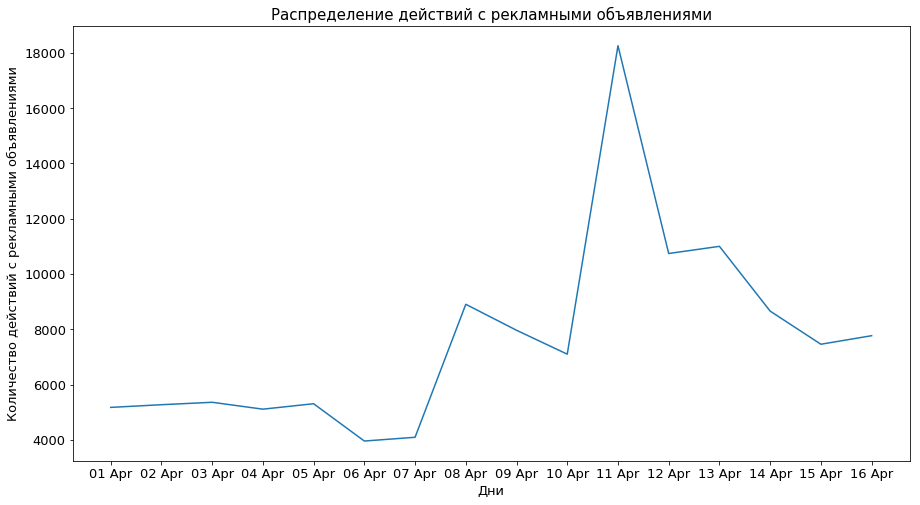

In [8]:
plt.figure(figsize=(15, 8))
plt.title('Распределение действий с рекламными объявлениями', fontsize=15)
plt.tick_params(labelsize=13)
plt.xlabel('Дни', fontsize=13)
plt.ylabel('Количество действий с рекламными объявлениями', fontsize=13)

plt.plot(data['day'].value_counts().sort_index());

Видим что произошло какое-то аномальное событие, 11 Апреля график подскочил и вырос до отметки 18К

Следующий график показывает, что аномалие связанно с тем что были просмотры а не клики, возможно был какой-то сбой системы, так как CPC - это плата за клик, второй график как раз нам это показывает.
Но все же на графике "Деиствия с рекламным постом" большое значение view, сильно выбивается от мер центральной тенденций. Возможно был праздник и люди засмотрелись на рекламный пост

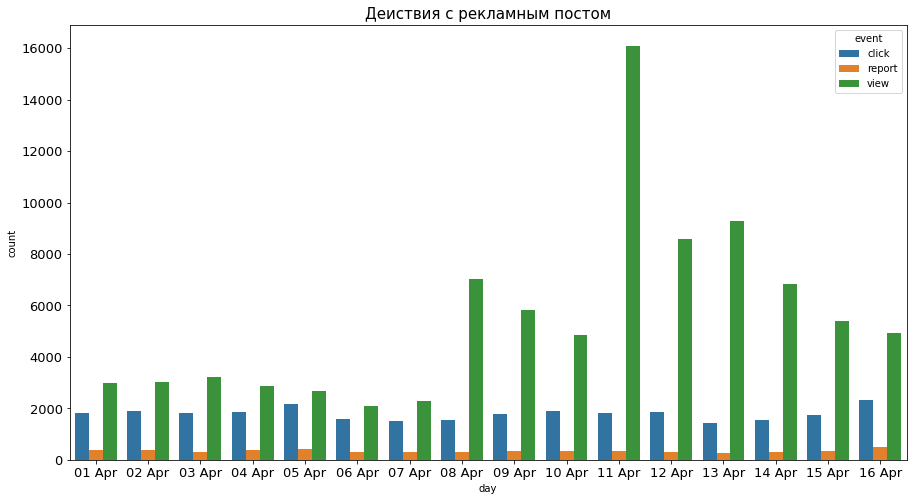

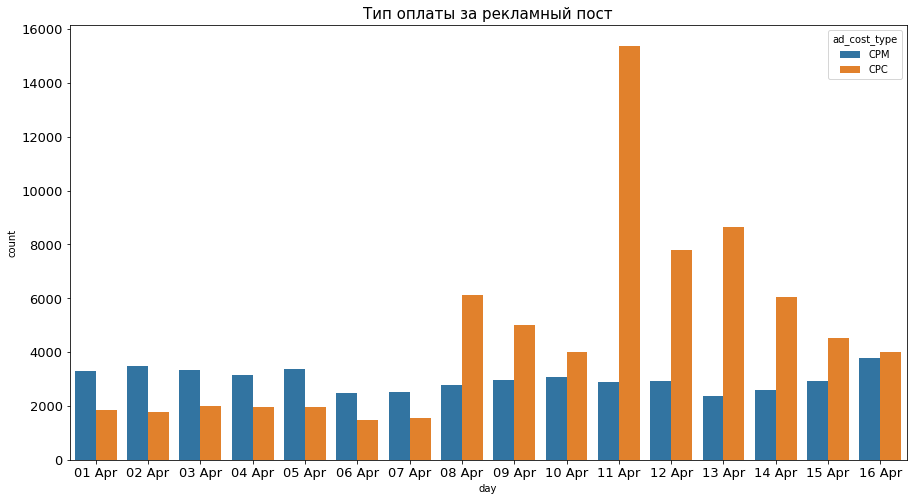

In [17]:
plt.figure(figsize=(15, 8))
plt.tick_params(labelsize=13)
plt.title('Деиствия с рекламным постом', fontsize=15)
sns.countplot(x='day', hue='event', data=data);
plt.show()

plt.figure(figsize=(15, 8))
plt.tick_params(labelsize=13)
plt.title('Тип оплаты за рекламный пост', fontsize=15)
sns.countplot(x='day', hue='ad_cost_type', data=data);
plt.show()

Давайте пойдем дальше и рассмотрим именно 11 апреля, какое-же было распределение по часам. Видим что резкий скачок пройзошел в промежутке времени с 5 часов утра до 12 часов дня.

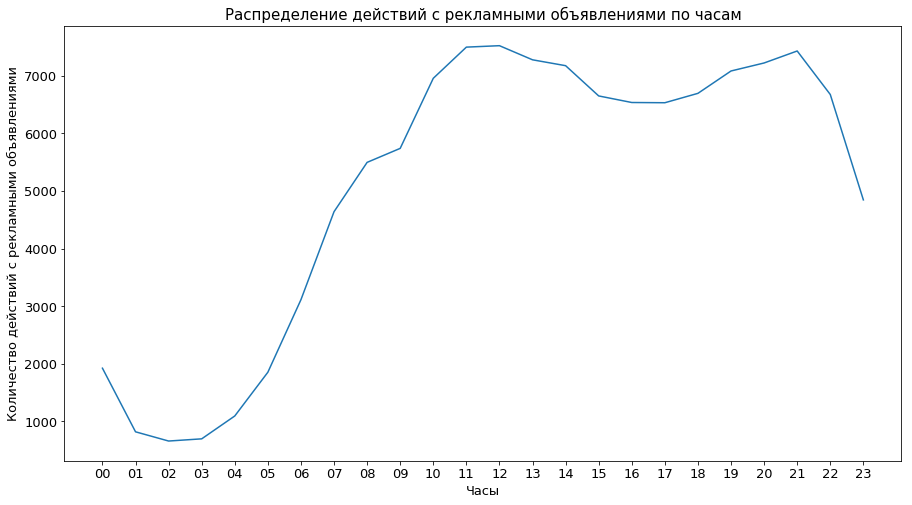

In [11]:
plt.figure(figsize=(15, 8))
plt.title('Распределение действий с рекламными объявлениями по часам', fontsize=15)
plt.tick_params(labelsize=13)
plt.xlabel('Часы', fontsize=13)
plt.ylabel('Количество действий с рекламными объявлениями', fontsize=13)
plt.plot(data['time_hour'].value_counts().sort_index());

In [12]:
data_11 = pd.DataFrame(data[data['day'] == '11 Apr'])
hour_time = pd.DataFrame(data_11.sort_values('time_hour'))

In [13]:
def visual(x, hue, name, data):
    plt.figure(figsize=(12, 7))
    plt.title(name, fontsize=15)
    plt.tick_params(labelsize=13)
    sns.countplot(x=x, hue=hue, data=hour_time)
    plt.show()

In [14]:
v = ['ad_cost_type', 'event', 'platform']
b = ['Тип платы за рекламу 11 Апреля', 'События с рекламным постом 11 Апреля', 'Платформа захода 11 Апреля']

Следующие три графика показывают нам, какие были события 11 Апреля, на втором и первом графике видно, что аномалие началось в 9 часов утра, приблизительно с палтформы Android

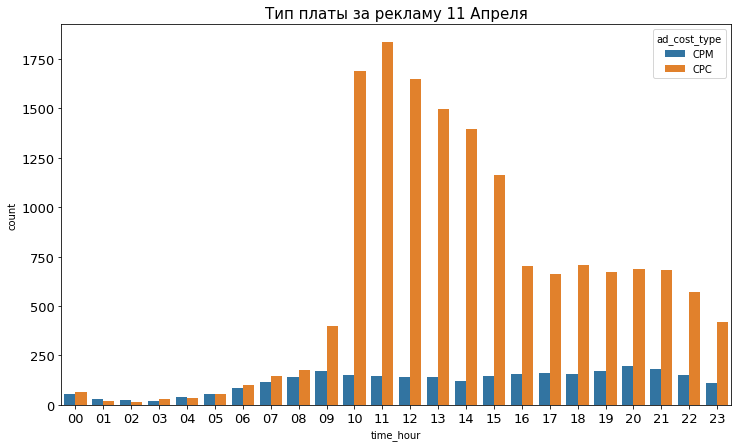

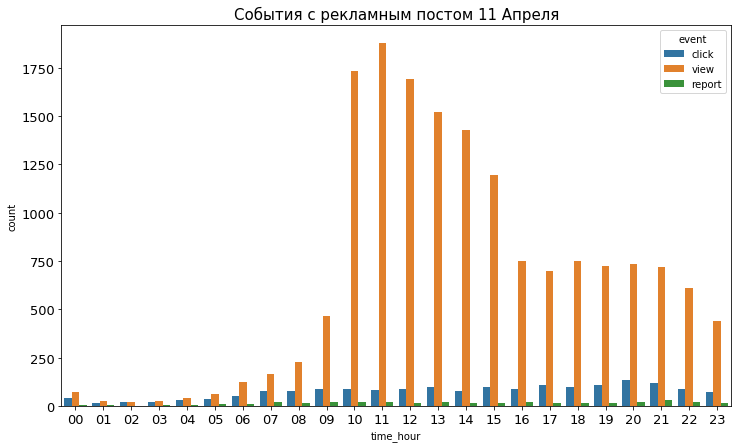

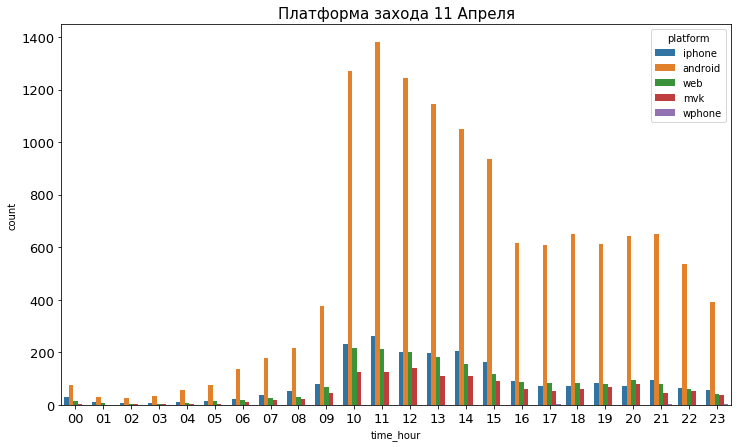

In [15]:
for hue, name in zip(v, b):
    visual('time_hour', hue, name, hour_time)

### 3.
Можно написать скрипт, который будет детектировать нарушение мер центральной тенденции по часам, дням и отправлять уведомление на почту.
Берем вчерашний день, изучаем рекламные действия, высчитываем меру центральной тенденции и сравниваем с результатами мер центральной тенденции последних 7 дней. Если выбивается на 10%, то отправляем уведомление.